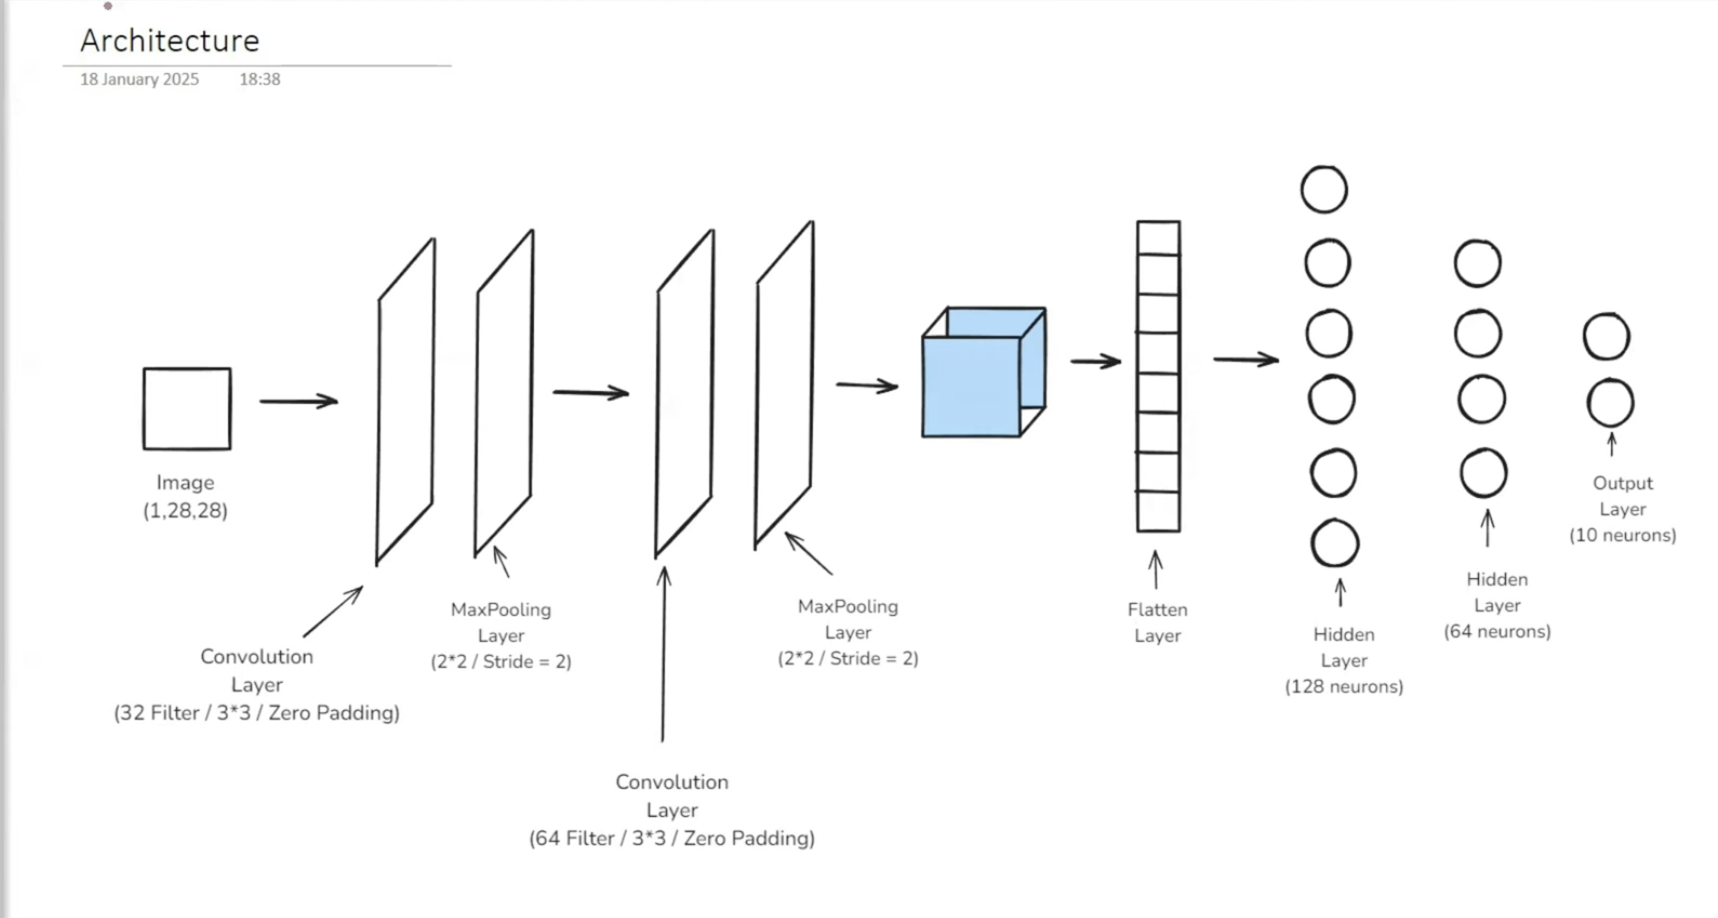

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(60000, 785)

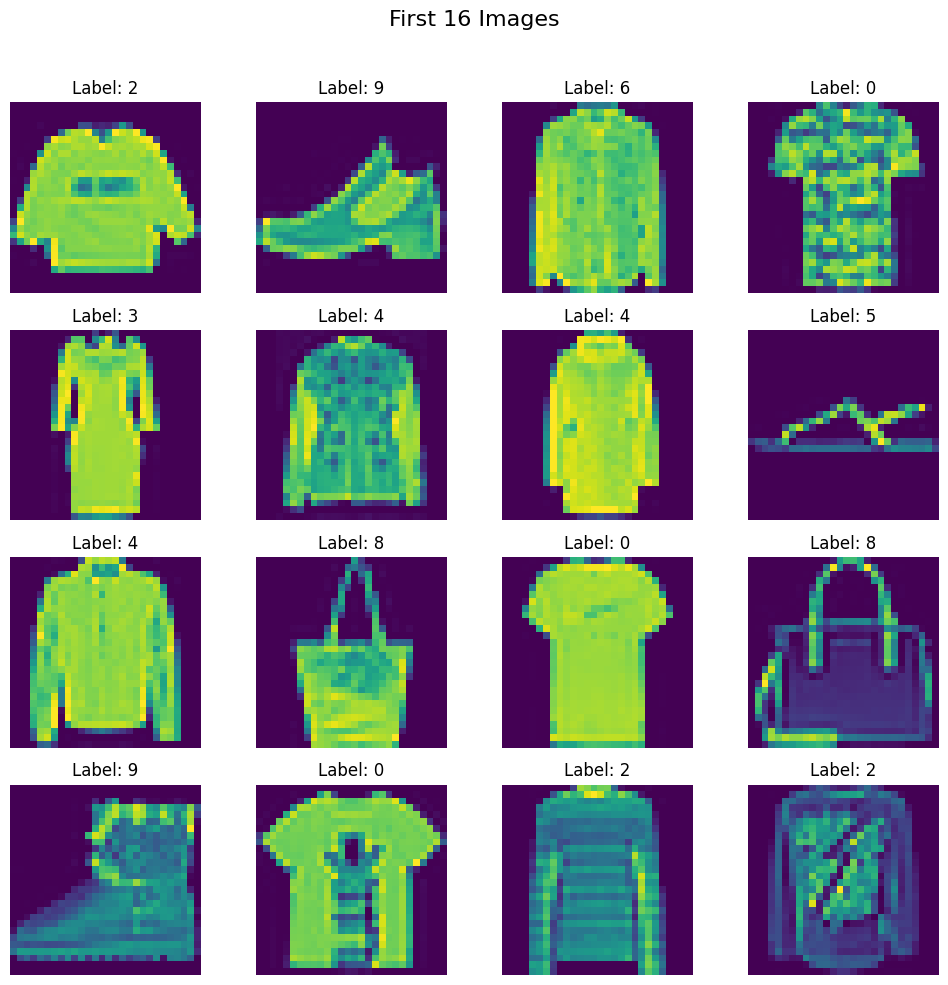

In [7]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [8]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train = X_train/255.0
X_test = X_test/255.0

In [12]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors             reshape(batch_size , channels , height , width) here we have grey scale image so channel = 1 and dim of image 28 X 28
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [13]:
train_dataset = CustomDataset(X_train, y_train)

In [14]:
test_dataset = CustomDataset(X_test, y_test)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [15]:
# create NN class

class MyNN(nn.Module):

  def __init__(self, input_channel):
    super().__init__()

    self.feature_extract = nn.Sequential(
        nn.Conv2d(in_channels= input_channel , out_channels= 32, kernel_size= 3, padding='same'),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels= 32 , out_channels= 64, kernel_size= 3, padding='same'),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(in_features= 64*7*7, out_features=128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout1d(0.3),

        nn.Linear(in_features=128, out_features=64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout1d(0.3),

        nn.Linear(in_features=64 , out_features=10)
    )


  def forward(self, x):
    x = self.feature_extract(x)
    x = self.classifier(x)

    return x




In [16]:
learning_rate = 0.01
epochs = 100

In [17]:
model = MyNN(1)

model.to(device)

lossFun = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [21]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = lossFun(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 1.4473637824058532
Epoch: 2 , Loss: 1.3376365075906118
Epoch: 3 , Loss: 1.3131726008256277
Epoch: 4 , Loss: 1.2887755534648895
Epoch: 5 , Loss: 1.2854124405384064
Epoch: 6 , Loss: 1.268863340695699
Epoch: 7 , Loss: 1.2627213235696158
Epoch: 8 , Loss: 1.2519726486206055
Epoch: 9 , Loss: 1.2445986506938935
Epoch: 10 , Loss: 1.2341831497351328
Epoch: 11 , Loss: 1.234370235522588
Epoch: 12 , Loss: 1.2369789500236512
Epoch: 13 , Loss: 1.2265266482830048
Epoch: 14 , Loss: 1.2181563131809234
Epoch: 15 , Loss: 1.2108953155676523
Epoch: 16 , Loss: 1.2257210196654003
Epoch: 17 , Loss: 1.2098437710603078
Epoch: 18 , Loss: 1.2075044778188069
Epoch: 19 , Loss: 1.20667360830307
Epoch: 20 , Loss: 1.1962628852526347
Epoch: 21 , Loss: 1.1895781666437786
Epoch: 22 , Loss: 1.1923997191588085
Epoch: 23 , Loss: 1.1929618440469105
Epoch: 24 , Loss: 1.1871183557510376
Epoch: 25 , Loss: 1.1904348847866058
Epoch: 26 , Loss: 1.19469393603007
Epoch: 27 , Loss: 1.1808802794615427
Epoch: 28 , Loss

In [22]:
model.eval()

MyNN(
  (feature_extract): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout1d(p=0.3, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [23]:
# evaluation on test data
total = 0
correct = 0
with torch.no_grad():
  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    _ , predicted = torch.max(outputs , 1)

    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

print(f'Accuracy: {100*correct/total}')

Accuracy: 92.08333333333333


In [24]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9999583333333333
